# Predicting a season based on Machine Learning Model
Winter 2019, INFO 370


### Members
William Kwok, Wonjo Barng, Kangwoo Choi, Vincent Widjaya 

## Introduction
Sports is an integral part of nearly all cultures. One of the sports which has lots of fans in the world is soccer, which we will call football throughout this paper. For years individuals have tried to use statistics to figure out what makes teams win, or to try to find out if their favorite teams are the best. Razali suggests that "the research for predicting the results of football matches outcome started as early as 1977 by Stafani R". The English Premier League (EPL), is one of the most popular and largest leagues in the world. In 2017, there were 5 clubs from EPL in top 10 teams by revenue.

In order to gain an understanding of what makes teams win at football, we will be exploring a few research questions:
<ul>
    <li>RQ1: Is there an association between the betting odds and the end results of a game? We may be able to find cases of illegal match fixing such as the scandals that occurred in late 2013 and produce a model that predicts if match fixing is happening.</li>
    <li>RQ2: Is there an association between the betting odds and statistics of a game? Studying this may also result in finding cases of illegal match fixing. For example, we can see if certain teams are under-performing in some games where bets are higher.</li>
    <li>RQ3: Is there an association between the game stats and the end results of a game? With this, we will be able to predict what factors are associated with winning the game. Coaches can use this information to their advantage and train their players against those conditions.</li>
</ul>

In answering these questions, we will be working with data from all England Premier League seasons from the 2014/2015 season to the current 2018/2019 season provided by [Football Data](http://www.football-data.co.uk/englandm.php). These datasets contain data pertaining to the game itself as well as a lot of bets associated with the game.

## Data Preparation
To answer these research questions, we selected features that would affect a result of game. There are no null/NAN value on our dataset. Based on our knowledge, we choose following features:
* `HomeTeam` - Name of the home team
* `AwayTeam` - Name of the away team
* `FTR` - Full time result (Home win, Away win, Draw)
* `FTHG` - Full time home team goals
* `FTAG` - Full time away team goals
* `HS` - Home team shots
* `AS` - Away team shots
* `HST` - Home team shots on target
* `AST` - Away team shots on target
* `HSGR` - Home team shots goal ratio (calculated)
* `ASGR` - Away team shots goal ratio (calculated)

We also include average betting odds from 6 companies, which are Bet365, Bet&win, Interwetten, Pinnacle, VC Bet, and William Hill. The reason that we select these companies is that these companies has valid data in every season. Lowest betting odds means that teams with lower betting odds are likely to win the game. If the betting odds for draw is the lowest, it means that people expect the game would draw. For example, if the betting odd for home team is 1.13, then if home team won the game, each people will get 1.13 times more money than they bet.
These are the following variables:
* `odd_home` - Average betting odds for Home Teams
* `odd_draw` - Average betting odds of betting on draw
* `odd_away` - Average betting odds for Away Teams

In [1]:
# Setting up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# ignore warning 
import warnings
warnings.filterwarnings("ignore")
# hide the code cell
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# get data frames previous 4 seasons and current season.
df_1415 = pd.read_csv('./data/1415.csv')
df_1516 =  pd.read_csv('./data/1516.csv')
df_1617 = pd.read_csv('./data/1617.csv')
df_1718 = pd.read_csv('./data/1718.csv')
df_1819 = pd.read_csv('./data/1819.csv')
df_total = df_1415.append(df_1516).append(df_1617).append(df_1718).append(df_1819)

#### Combined Dataset

In [3]:
df_total.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,Referee,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH
0,3.0,19.0,1.0,4.0,2.0,2.0,Crystal Palace,15.0,6.5,1.25,...,J Moss,12.00,5.75,1.25,10.50,6.25,1.25,12.0,5.5,1.25
1,6.0,10.0,0.0,13.0,3.0,1.0,Everton,2.4,3.4,3.20,...,M Jones,2.38,3.30,3.00,2.40,3.40,3.20,2.4,3.1,3.10
2,0.0,20.0,0.0,5.0,4.0,4.0,Swansea,11.0,5.0,1.36,...,M Dean,8.00,5.00,1.36,10.00,5.20,1.36,9.0,4.5,1.36
3,9.0,10.0,0.0,11.0,4.0,2.0,Hull,3.1,3.3,2.50,...,C Pawson,2.88,3.25,2.50,3.12,3.20,2.55,2.9,3.0,2.60
4,8.0,9.0,0.0,7.0,2.0,3.0,Aston Villa,4.5,3.5,1.95,...,A Taylor,4.00,3.40,1.95,4.75,3.30,1.95,4.2,3.2,1.95


In [4]:
# Clean data function
def clean_data(df):
    data = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST']]
    data['HSGR'] = data['FTHG']/data['HS']
    data['ASGR'] = data['FTAG']/data['AS']
    data = data.replace([np.inf, -np.inf], 0)
    bet_home = df[['B365H','BWH','IWH','PSH','VCH','WHH']].mean(axis=1)
    bet_draw = df[['B365D','BWD','IWD','PSD','VCD','WHD']].mean(axis=1)
    bet_away = df[['B365A','BWA','IWA','PSA','VCA','WHA']].mean(axis=1)
    
    
    data['odd_home'] = bet_home
    data['odd_draw'] = bet_draw
    data['odd_away'] = bet_away
    
    data.dropna()
    
    return data

##### Dataset Format after data cleaning

In [5]:
# clean data 
df_total = clean_data(df_total)
df_total.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HSGR,ASGR,odd_home,odd_draw,odd_away
0,Arsenal,Crystal Palace,2.0,1.0,H,14.0,4.0,6.0,2.0,0.142857,0.250000,1.260000,5.866667,12.085000
1,Leicester,Everton,2.0,2.0,D,11.0,13.0,3.0,3.0,0.181818,0.153846,3.073333,3.296667,2.393333
2,Man United,Swansea,1.0,2.0,A,14.0,5.0,5.0,4.0,0.071429,0.400000,1.363333,4.925000,9.600000
3,QPR,Hull,0.0,1.0,A,19.0,11.0,6.0,4.0,0.000000,0.090909,2.488333,3.193333,3.015000
4,Stoke,Aston Villa,0.0,1.0,A,12.0,7.0,2.0,2.0,0.000000,0.142857,1.958333,3.345000,4.250000


In [6]:
# clean data for each individual dataset
data_1415 = clean_data(pd.read_csv('./data/1415.csv'))
data_1415.drop(df_1415.tail(1).index,inplace=True)
data_1516 = clean_data(pd.read_csv('./data/1516.csv'))
data_1617 = clean_data(pd.read_csv('./data/1617.csv'))
data_1718 = clean_data(pd.read_csv('./data/1718.csv'))
data_1819 = clean_data(pd.read_csv('./data/1819.csv'))

In [7]:
# a function that gets the average of betting odds
def average_betting(df):
    betting_accuracies = []
    for index, row in df.iterrows():
        if(row['FTR'] == 'H' and row['odd_home'] < row['odd_away'] and row['odd_home'] < row['odd_draw']):
            betting_accuracies.append(1)
        elif(row['FTR'] == 'D' and row['odd_draw'] < row['odd_away'] and row['odd_draw'] < row['odd_home']):
            betting_accuracies.append(1)
        elif(row['FTR'] == 'A' and row['odd_away'] < row['odd_home'] and row['odd_away'] < row['odd_draw']):
            betting_accuracies.append(1)
        else:
            betting_accuracies.append(0)
        
    return np.mean(betting_accuracies)

In [8]:
# set time trend on plot
time = [average_betting(data_1415),
        average_betting(data_1516), 
        average_betting(data_1617), 
        average_betting(data_1718), 
        average_betting(data_1819)]

### Finding patterns from Dataset

#### Accuracy of betting odds

We expected that the accuracy would increase, but there is no pattern on betting accuracy over time.

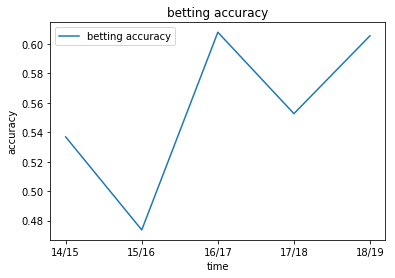

In [9]:
# Betting accuracy by timeline ()
plt.plot(["14/15", "15/16", "16/17", "17/18", "18/19"], time, label='betting accuracy')
plt.legend()
plt.title('betting accuracy')
plt.xlabel('time')
plt.ylabel('accuracy')
plt.show()

#### Actual Result vs Betting odds

We compare the average betting odds and actual results. When home team wins the game, the proability of matching betting odds with actual results is around 84%. When the result of the game is draw, the proability of matching betting odds with actual results is around 0% since people expect to draw less than winning or losing a game. When away team win the game, the proability of matching betting odds with actual results is around 57%.

In [10]:
# getting accuracy about how an actual result matched with lowest betting odds.
def accuracy(df):
    home = 0
    draw = 0
    away = 0
    for index, row in df.iterrows():
        if (row['odd_home'] < row['odd_away'] and row['odd_home'] < row['odd_draw']):
            home = home+1
        elif (row['odd_draw'] < row['odd_away'] and row['odd_draw'] < row['odd_home']):
            draw = draw+1
        else:
            away = away+1
            
    return [home / len(df), draw / len(df), away / len(df)]

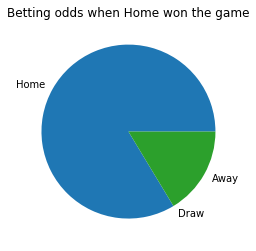

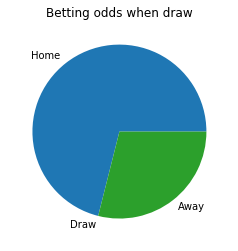

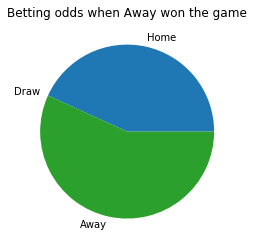

In [11]:
# draw pie chart for getting proportation of betting odds for matched result.
plt.pie(accuracy(df_total.loc[df_total['FTR'] == 'H']), labels=['Home', 'Draw', 'Away'])
plt.title('Betting odds when Home won the game')
plt.show()
plt.pie(accuracy(df_total.loc[df_total['FTR'] == 'D']), labels=['Home', 'Draw', 'Away'])
plt.title('Betting odds when draw')
plt.show()
plt.pie(accuracy(df_total.loc[df_total['FTR'] == 'A']), labels=['Home', 'Draw', 'Away'])
plt.title('Betting odds when Away won the game')
plt.show()

#### Home vs Away
It shows the number of wins for home and away team. Home team used to take advantages. 

In [12]:
## get distribution of the result
def getDistResult(data):
    arr = [0,0,0]
    for index, row in data.iterrows():
        if row.FTR == 'H':
            arr[0] += 1
        elif row.FTR == 'D':
            arr[1] += 1
        else:
            arr[2] += 1
    return arr

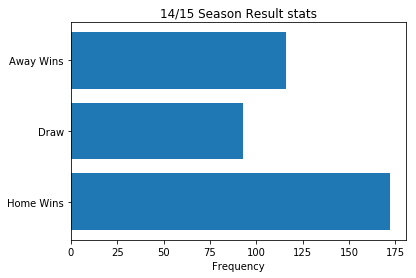

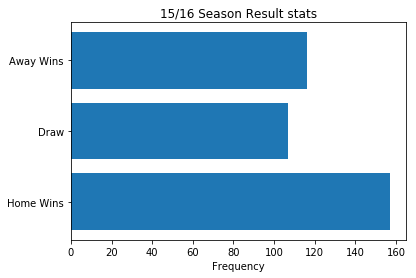

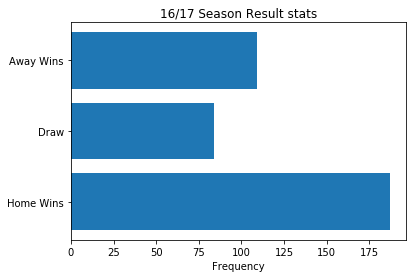

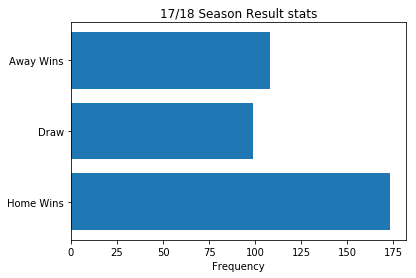

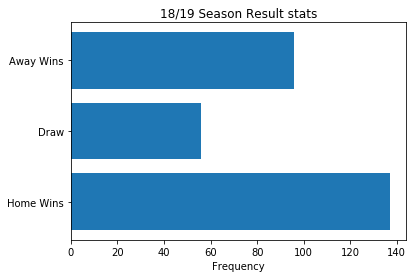

In [13]:
# by season home or away
result = ['Home Wins', 'Draw', 'Away Wins']
plt.barh(result, getDistResult(df_1415))
plt.xlabel('Frequency')
plt.title('14/15 Season Result stats')
plt.show()

plt.barh(result, getDistResult(df_1516))
plt.xlabel('Frequency')
plt.title('15/16 Season Result stats')
plt.show()

plt.barh(result, getDistResult(df_1617))
plt.xlabel('Frequency')
plt.title('16/17 Season Result stats')
plt.show()

plt.barh(result, getDistResult(df_1718))
plt.xlabel('Frequency')
plt.title('17/18 Season Result stats')
plt.show()

plt.barh(result, getDistResult(df_1819))
plt.xlabel('Frequency')
plt.title('18/19 Season Result stats')
plt.show()

## Modeling

In [14]:
# Clean data function from Kangwoo's notebook
def clean_data_poisson(df):
    data = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST']]
    data['HSGR'] = data['FTHG']/data['HS']
    data['ASGR'] = data['FTAG']/data['AS']
    data = data.replace([np.inf, -np.inf], 0)
#     bet_home = df[['B365H','BWH','IWH','PSH','VCH','WHH']].mean(axis=1)
#     bet_draw = df[['B365D','BWD','IWD','PSD','VCD','WHD']].mean(axis=1)
#     bet_away = df[['B365A','BWA','IWA','PSA','VCA','WHA']].mean(axis=1)
    
    
#     data['odd_home'] = bet_home
#     data['odd_draw'] = bet_draw
#     data['odd_away'] = bet_away
    
    data.dropna()
    
    ############### New stuff
    team_scores = {}
    team_shots = {}
    HomeAvgAllTimeSoFar = []
    HomeHighAllTimeSoFar = []
    HomeLowAllTimeSoFar = []
    HomeTotalGoals = []
    HomeTotalShots = []
    HomeTotalAccuracy = []
    AwayAvgAllTimeSoFar = []
    AwayHighAllTimeSoFar = []
    AwayLowAllTimeSoFar = []
    AwayTotalGoals = []
    AwayTotalShots = []
    AwayTotalAccuracy = []
    for index, row in data.iterrows():
        # Add values to all the rows before adding to the team scores
        home_team = row["HomeTeam"]
        away_team = row["AwayTeam"]
        if home_team not in team_scores:
            team_scores[home_team] = []
        if away_team not in team_scores:
            team_scores[away_team] = []
        if home_team not in team_shots:
            team_shots[home_team] = []
        if away_team not in team_shots:
            team_shots[away_team] = []
        home_team_scores = team_scores[home_team]
        away_team_scores = team_scores[away_team]
        home_team_shots = team_shots[home_team]
        away_team_shots = team_shots[away_team]
        if len(home_team_scores) < 1:
            HomeAvgAllTimeSoFar.append(0)
            HomeHighAllTimeSoFar.append(0)
            HomeLowAllTimeSoFar.append(0)
        else: 
            HomeAvgAllTimeSoFar.append(np.mean(home_team_scores))
            HomeHighAllTimeSoFar.append(np.max(home_team_scores).astype("float"))
            HomeLowAllTimeSoFar.append(np.min(home_team_scores).astype("float"))
        if len(away_team_scores) < 1:
            AwayAvgAllTimeSoFar.append(0)
            AwayHighAllTimeSoFar.append(0)
            AwayLowAllTimeSoFar.append(0)
        else: 
            AwayAvgAllTimeSoFar.append(np.mean(away_team_scores))
            AwayHighAllTimeSoFar.append(np.max(away_team_scores).astype("float"))
            AwayLowAllTimeSoFar.append(np.min(away_team_scores).astype("float"))
        s_Home_Scores = np.sum(home_team_scores)
        s_Home_Shots = np.sum(home_team_shots)
        s_Away_Scores = np.sum(away_team_scores)
        s_Away_Shots = np.sum(away_team_shots)
        HomeTotalGoals.append(s_Home_Scores)
        HomeTotalShots.append(s_Home_Shots)
        HomeTotalAccuracy.append(np.nan_to_num(s_Home_Scores/s_Home_Shots))
        AwayTotalGoals.append(s_Away_Scores)
        AwayTotalShots.append(s_Away_Shots)
        AwayTotalAccuracy.append(np.nan_to_num(s_Away_Scores/s_Away_Shots))
        # Add to team scores
        team_scores[home_team].append(row["FTHG"])
        team_scores[away_team].append(row["FTAG"])
        team_shots[home_team].append(row["HS"])
        team_shots[away_team].append(row["AS"])
        
    data["HomeAvgAllTimeSoFar"] = HomeAvgAllTimeSoFar
    data["HomeHighAllTimeSoFar"] = HomeHighAllTimeSoFar
    data["HomeLowAllTimeSoFar"] = HomeLowAllTimeSoFar
    data["AwayAvgAllTimeSoFar"] = AwayAvgAllTimeSoFar
    data["AwayHighAllTimeSoFar"] = AwayHighAllTimeSoFar
    data["AwayLowAllTimeSoFar"] = AwayLowAllTimeSoFar 
    data["HomeTotalGoals"] = HomeTotalGoals
    data["HomeTotalShots"] = HomeTotalShots
    data["HomeTotalAccuracy"] = HomeTotalAccuracy
    data["AwayTotalGoals"] = AwayTotalGoals
    data["AwayTotalShots"] = AwayTotalShots
    data["AwayTotalAccuracy"] = AwayTotalAccuracy
    #####################
    data.dropna()
    
    return data

In [15]:
# clean data for each individual dataset
data_1415_poi = clean_data_poisson(pd.read_csv('./data/1415.csv'))
data_1415_poi.drop(df_1415.tail(1).index,inplace=True)
data_1516_poi = clean_data_poisson(pd.read_csv('./data/1516.csv'))
data_1617_poi = clean_data_poisson(pd.read_csv('./data/1617.csv'))
data_1718_poi = clean_data_poisson(pd.read_csv('./data/1718.csv'))
data_1819_poi = clean_data_poisson(pd.read_csv('./data/1819.csv'))

### (1) Using Poisson

We attempted to run a poisson model on the data to produce a guess for if the Home team would win, Away team, or if it would end up in a draw. We encoded the values using `sklearn`'s `LabelEncoder` function. Then we split the data into test and training data. We then plugged it into a general linear model with a Poisson family using the following formulas: `FTR ~ HomeTeam + AwayTeam`, `FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + AwayTotalAccuracy`, and `FTR ~ HomeAvgAllTimeSoFar + HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + AwayTotalAccuracy`.

Here are a list of the values we used in these models:
* `HomeTeam` - Name of the home team
* `AwayTeam` - Name of the away team
* `HomeAvgAllTimeSoFar` - Average of all scores from each game the home team has played by that point in time.
* `HomeHighAllTimeSoFar` - Highest of all scores from each game the home team has played by that point in time.
* `HomeLowAllTimeSoFar` - Lowest of all scores from each game the home team has played by that point in time.
* `AwayAvgAllTimeSoFar` - Average of all scores from each game the away team has played by that point in time.
* `AwayHighAllTimeSoFar` - Highest of all scores from each game the away team has played by that point in time.
* `AwayLowAllTimeSoFar` - Lowest of all scores from each game the away team has played by that point in time.
* `HomeTotalGoals` - Total home goals to date
* `HomeTotalShots` - Total home shots to date
* `HomeTotalAccuracy` - Home accuracy to date
* `AwayTotalGoals` - Total away goals to date
* `AwayTotalShots` - Total away shots to date
* `AwayTotalAccuracy` - Away accuracy to date

### For each year

First we ran this model on the separate datasets. At first, we tried out just the Home team and Away team names as factors in the model, similar (but not exactly!) to [David Sheehan's study](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/). We received these accuracy scores.

* 14-15: 0.368
* 15-16: 0.329
* 16-17: 0.395
* 17-18: 0.382
* 18-19: 0.431

This very simple model seems to be able to guess it more than a third of the time mostly. However, that isn't as good as we would like. It is just slightly better than guessing at random. In 2015-2016, it would have been _worse_ than guessing at random. 

We then tried with only the factors we generated and found a dip in performance for most of the years.

* 14-15: 0.289
* 15-16: 0.289
* 16-17: 0.355
* 17-18: 0.382
* 18-19: 0.362

Finally, we tried both the home team and away team names as factors combined with our factors, and we saw a slight improvement in most of the scores.

* 14-15: 0.368
* 15-16: 0.382
* 16-17: 0.408
* 17-18: 0.395
* 18-19: 0.362

We theorize that 18-19 is so low accuracy because there haven't been as many games played thus far. 

### Combined

We also ran the model on all the combined datasets. Note that while combined, the "All Time" factors are localized to the season the data point came from, meaning there are no "lifetime" data points besides the name of the team (doing so doesn't provide any increase in accuracy). For the model that just had team names as factors, we received an accuracy of 0.387. For the model with just our factors, we received an accuracy of 0.362. For the model with those combined, we received an accuracy of 0.398. 

If we take a look at the summary of the model with the team names as factors alongside our factors, we see that some of the factors are significant. To contrast [David Sheehan's study](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/), we didn't receive as many significant p values because we did not combine `HomeTeam` and `AwayTeam` into a single `team` variable for this specific analysis. 

In [16]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1415 = LabelEncoder() 
encoder_1415.fit(data_1415_poi["FTR"])
data_1415_poi["FTR"] = encoder_1415.transform(data_1415_poi["FTR"])

# split into training and test data
train_1415, valid_1415, train_labels_1415, valid_labels_1415 = train_test_split(
    data_1415_poi.drop("FTR", axis=1),
    data_1415_poi["FTR"],
    test_size=0.2,
    random_state=123
)

# Combine the training data and labels to fit into generalized linear model
train_1415_all = train_1415
train_1415_all["FTR"] = train_labels_1415

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1415_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1415))
a1 = accuracy_score(valid_labels_1415, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1415_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1415))
a2 = accuracy_score(valid_labels_1415, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam ", 
            data=train_1415_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1415))
a3 = accuracy_score(valid_labels_1415, pred)

a1, a2, a3

(0.3684210526315789, 0.2894736842105263, 0.3684210526315789)

In [17]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1516 = LabelEncoder()
encoder_1516.fit(data_1516_poi["FTR"])
data_1516_poi["FTR"] = encoder_1516.transform(data_1516_poi["FTR"])

# split into training and test data
train_1516, valid_1516, train_labels_1516, valid_labels_1516 = train_test_split(
    data_1516_poi.drop("FTR", axis=1),
    data_1516_poi["FTR"],
    test_size=0.2,
    random_state=123
)

# Combine the training data and labels to fit into generalized linear model
train_1516_all = train_1516
train_1516_all["FTR"] = train_labels_1516

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1516_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1516))
a1 = accuracy_score(valid_labels_1516, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1516_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1516))
a2 = accuracy_score(valid_labels_1516, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam", 
            data=train_1516_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1516))
a3 = accuracy_score(valid_labels_1516, pred)

a1, a2, a3

(0.3815789473684211, 0.2894736842105263, 0.32894736842105265)

In [18]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1617 = LabelEncoder()
encoder_1617.fit(data_1617_poi["FTR"])
data_1617_poi["FTR"] = encoder_1617.transform(data_1617_poi["FTR"])

# split into training and test data
train_1617, valid_1617, train_labels_1617, valid_labels_1617 = train_test_split(
    data_1617_poi.drop("FTR", axis=1),
    data_1617_poi["FTR"],
    test_size=0.2,
    random_state=123
)

# Combine the training data and labels to fit into generalized linear model
train_1617_all = train_1617
train_1617_all["FTR"] = train_labels_1617

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1617_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1617))
a1 = accuracy_score(valid_labels_1617, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1617_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1617))
a2 = accuracy_score(valid_labels_1617, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam", 
            data=train_1617_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1617))
a3 = accuracy_score(valid_labels_1617, pred)

a1, a2, a3

(0.40789473684210525, 0.35526315789473684, 0.39473684210526316)

In [ ]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1718 = LabelEncoder()
encoder_1718.fit(data_1718_poi["FTR"])
data_1718_poi["FTR"] = encoder_1718.transform(data_1718_poi["FTR"])

# split into training and test data
train_1718, valid_1718, train_labels_1718, valid_labels_1718 = train_test_split(
    data_1718_poi.drop("FTR", axis=1),
    data_1718_poi["FTR"],
    test_size=0.2,
    random_state=123
)

# Combine the training data and labels to fit into generalized linear model
train_1718_all = train_1718
train_1718_all["FTR"] = train_labels_1718

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1718_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1718))
a1 = accuracy_score(valid_labels_1718, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1718_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1718))
a2 = accuracy_score(valid_labels_1718, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam", 
            data=train_1718_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1718))
a3 = accuracy_score(valid_labels_1718, pred)

a1, a2, a3

(0.39473684210526316, 0.3815789473684211, 0.3815789473684211)

In [ ]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1819 = LabelEncoder()
encoder_1819.fit(data_1819_poi["FTR"])
data_1819_poi["FTR"] = encoder_1819.transform(data_1819_poi["FTR"])

# split into training and test data
train_1819, valid_1819, train_labels_1819, valid_labels_1819 = train_test_split(
    data_1819_poi.drop("FTR", axis=1),
    data_1819_poi["FTR"],
    test_size=0.2,
    random_state=123
)

# Combine the training data and labels to fit into generalized linear model
train_1819_all = train_1819
train_1819_all["FTR"] = train_labels_1819

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1819_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1819))
a1 = accuracy_score(valid_labels_1819, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_1819_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1819))
a2 = accuracy_score(valid_labels_1819, pred)

# Use Poisson to calculate
m = smf.glm(formula="FTR ~ HomeTeam + AwayTeam", 
            data=train_1819_all, family=sm.families.Poisson()).fit()

# Predict and find accuracy
pred = np.round(m.predict(valid_1819))
a3 = accuracy_score(valid_labels_1819, pred)

a1, a2, a3

(0.3620689655172414, 0.3620689655172414, 0.43103448275862066)

In [ ]:
# concatenate all data
all_data_poi = pd.concat([data_1415_poi, data_1516_poi, data_1617_poi, data_1718_poi, data_1819_poi], axis=0, ignore_index=True)

In [ ]:
encoder_all = LabelEncoder()
encoder_all.fit(all_data_poi["FTR"])
all_data_poi["FTR"] = encoder_all.transform(all_data_poi["FTR"])
train_all, valid_all, train_labels_all, valid_labels_all = train_test_split(
    all_data_poi.drop("FTR", axis=1),
    all_data_poi["FTR"],
    test_size=0.2,
    random_state=123
)

train_all_allcols = train_all
train_all_allcols["FTR"] = train_labels_all
m1 = smf.glm(formula="FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_all_allcols, family=sm.families.Poisson()).fit()
pred = np.round(m1.predict(valid_all))
pred[np.isnan(pred)] = 1
a1 = accuracy_score(valid_labels_all, pred)

m2 = smf.glm(formula="FTR ~ HomeAvgAllTimeSoFar + \
                    HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + \
                    AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + \
                    HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + \
                    AwayTotalAccuracy", 
            data=train_all_allcols, family=sm.families.Poisson()).fit()

pred = np.round(m2.predict(valid_all))
pred[np.isnan(pred)] = 1
a2 = accuracy_score(valid_labels_all, pred)

m3 = smf.glm(formula="FTR ~ HomeTeam + AwayTeam", 
            data=train_all_allcols, family=sm.families.Poisson()).fit()

pred = np.round(m3.predict(valid_all))
pred[np.isnan(pred)] = 1
a3 = accuracy_score(valid_labels_all, pred)


a1, a2, a3

(0.39779005524861877, 0.36187845303867405, 0.3867403314917127)

In [ ]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    FTR   No. Observations:                 1447
Model:                            GLM   Df Residuals:                     1378
Model Family:                 Poisson   Df Model:                           68
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1782.6
Date:                Tue, 12 Mar 2019   Deviance:                       1145.1
Time:                        23:49:23   Pearson chi2:                     865.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2067      0.216      0.956      0.339      -0.217       0.630
HomeTeam[T.Aston Villa]       -0.8236      0.267     -3.083      0.002      -1.347      -0.300
HomeTeam[T.Bournemouth]       -0.3208      0.171     -1.879      0.060      -0.655       0.014
HomeTeam[T.Brighton]          -0.1526      0.217     -0.704      0.482      -0.578       0.273
HomeTeam[T.Burnley]           -0.3196      0.189     -1.692      0.091      -0.690       0.051
HomeTeam[T.Cardiff]           -0.6427      0.344     -1.870      0.061      -1.316       0.031
HomeTeam[T.Chelsea]           -0.0966      0.133     -0.725      0.468      -0.358       0.165
HomeTeam[T.Crystal Palace]    -0.5529      0.171     -3.232      0.001      -0.888      -0.218
HomeTeam[T.Everton]           -0.2673      0.152     -1.762      0.078      -0.565       0.030
HomeTeam[T.Fulham]            -0.7869      0.398     -1.977      0.048      -1.567      -0.007
HomeTeam[T.Huddersfield]      -0.6784      0.278     -2.440      0.015      -1.223      -0.133
HomeTeam[T.Hull]              -0.4553      0.221     -2.061      0.039      -0.888      -0.022
HomeTeam[T.Leicester]         -0.2157      0.155     -1.391      0.164      -0.520       0.088
HomeTeam[T.Liverpool]         -0.1082      0.135     -0.800      0.424      -0.373       0.157
HomeTeam[T.Man City]          -0.0918      0.142     -0.647      0.518      -0.370       0.186
HomeTeam[T.Man United]        -0.0234      0.135     -0.174      0.862      -0.288       0.241
HomeTeam[T.Middlesbrough]     -0.4627      0.311     -1.487      0.137      -1.073       0.147
HomeTeam[T.Newcastle]         -0.3958      0.180     -2.199      0.028      -0.749      -0.043
HomeTeam[T.Norwich]           -0.6440      0.323     -1.996      0.046      -1.276      -0.012
HomeTeam[T.QPR]               -0.4678      0.284     -1.646      0.100      -1.025       0.089
HomeTeam[T.Southampton]       -0.3345      0.155     -2.163      0.031      -0.638      -0.031
HomeTeam[T.Stoke]             -0.3278      0.171     -1.914      0.056      -0.664       0.008
HomeTeam[T.Sunderland]        -0.6836      0.218     -3.132      0.002      -1.111      -0.256
HomeTeam[T.Swansea]           -0.4001      0.182     -2.196      0.028      -0.757      -0.043
HomeTeam[T.Tottenham]         -0.1366      0.137     -0.997      0.319      -0.405       0.132
HomeTeam[T.Watford]           -0.2621      0.171     -1.529      0.126      -0.598       0.074
HomeTeam[T.West Brom]         -0.5356      0.186     -2.887      0.004      -0.899      -0.172
HomeTeam[T.West Ham]          -0.3562      0.157     -2.274      0.023      -0.663      -0.049
HomeTeam[T.Wolves]            -0.2620      0.301     -0.871      0.384      -0.851       0.328
AwayTeam[T.Aston Villa]        0.3467      0.219      1.581      0.114      -0.083       0.776
AwayTeam[T.Bournemouth]    

In [ ]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    FTR   No. Observations:                 1447
Model:                            GLM   Df Residuals:                     1434
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1818.3
Date:                Tue, 12 Mar 2019   Deviance:                       1216.6
Time:                        23:49:24   Pearson chi2:                     896.
No. Iterations:                     5   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0160      0.122     -0.131      0.896      -0.255       0.223
HomeAvgAllTimeSoFar      0.3790      0.114      3.314      0.001       0.155       0.603
HomeHighAllTimeSoFar     0.0088      0.031      0.282      0.778      -0.052       0.070
HomeLowAllTimeSoFar     -0.1273      0.093     -1.363      0.173      -0.310       0.056
AwayAvgAllTimeSoFar     -0.4953      0.134     -3.688      0.000      -0.759      -0.232
AwayHighAllTimeSoFar     0.0206      0.030      0.690      0.490      -0.038       0.079
AwayLowAllTimeSoFar      0.0202      0.107      0.188      0.851      -0.190       0.230
HomeTotalGoals          -0.0016      0.006     -0.274      0.784      -0.013       0.010
HomeTotalShots           0.0011      0.001      1.368      0.171      -0.000       0.003
HomeTotalAccuracy       -1.6430      1.321     -1.244      0.213      -4.231       0.946
AwayTotalGoals          -0.0033      0.006     -0.516      0.606      -0.016       0.009
AwayTotalShots          -0.0007      0.001     -0.864      0.387      -0.002       0.001
AwayTotalAccuracy        3.6994      1.458      2.537      0.011       0.842       6.557
========================================================================================
"""

### (2) Prediction with Betting odds

In [ ]:
def restructure(df):
    df = df.copy()
    df['goals_h_a'] = df['FTHG'] - df['FTAG']
    df['total_h_a'] = df['HS'] - df['AS']

    H_GT = [] # home games total so far
    H_W = [] # home wins so far
    H_WR = [] # home win rate so far
    H_avg_diff = [] # home avg goals diff

    A_GT = [] # away games total so far
    A_W = [] # away wins so far
    A_WR = [] #away win rate so far
    A_avg_diff = [] # away avg goals diff

    for i in range(len(df)):
        home = df.loc[i, 'HomeTeam']
        away = df.loc[i, 'AwayTeam']
        
        home_h_games = df[df['HomeTeam'] == home].loc[:i]['goals_h_a']
        home_a_games = df[df['AwayTeam'] == home].loc[:i]['goals_h_a'] * -1
        home_games = home_h_games.append(home_a_games)
        
        away_h_games = df[df['HomeTeam'] == away].loc[:i]['goals_h_a']
        away_a_games = df[df['AwayTeam'] == away].loc[:i]['goals_h_a'] * -1
        away_games = away_h_games.append(away_a_games)
        
        H_GT.append(len(home_games))
        A_GT.append(len(away_games))
        
        H_W.append((home_games > 0).sum() + (home_games == 0).sum() * 0.5)
        A_W.append((away_games > 0).sum() + (away_games == 0).sum() * 0.5)
        
        H_WR.append(H_W[i] / H_GT[i])
        A_WR.append(A_W[i] / A_GT[i])
        
        H_avg_diff.append(home_games.mean())
        A_avg_diff.append(away_games.mean())
    
    df['H_GT'] = H_GT
    df['H_W'] = H_W
    df['H_WR'] = H_WR
    df['H_avg_diff'] = H_avg_diff
    df['A_GT'] = A_GT
    df['A_W'] = A_W
    df['A_WR'] = A_WR
    df['A_avg_diff'] = A_avg_diff
    return df

def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def getLastTeamStats(df):
    team_stats = {}
    for team in df.HomeTeam.unique():
        temp_df = df[::-1].reset_index(drop=True)
        for i in range(len(temp_df)):
            game = temp_df.loc[i]
            if team == game['HomeTeam']:
                stats = {}
                stats['W'] = game['H_W']
                stats['WR'] = game['H_WR']
                stats['avg_diff'] = game['H_avg_diff']
                team_stats[team] = stats
            elif team == game['AwayTeam']:
                stats = {}
                stats['W'] = game['A_W']
                stats['WR'] = game['A_WR']
                stats['avg_diff'] = game['A_avg_diff']
                team_stats[team] = stats
            if team in team_stats:
                break
    return team_stats

In [ ]:
# Clean and restructure all the data
data_1415 = clean_data(pd.read_csv('./data/1415.csv'))
data_1415.drop(data_1415.tail(1).index,inplace=True)
data_1516 = clean_data(pd.read_csv('./data/1516.csv'))
data_1617 = clean_data(pd.read_csv('./data/1617.csv'))
data_1718 = clean_data(pd.read_csv('./data/1718.csv'))
data_1819 = clean_data(pd.read_csv('./data/1819.csv'))

df_1415 = restructure(data_1415)
df_1516 = restructure(data_1516)
df_1617 = restructure(data_1617)
df_1718 = restructure(data_1718)
df_1819 = restructure(data_1819)

df_past_seasons = df_1415.copy()
df_past_seasons = df_past_seasons.append(df_1516)
df_past_seasons = df_past_seasons.append(df_1617)
df_past_seasons = df_past_seasons.append(df_1718)
df_past_seasons = df_past_seasons.reset_index(drop=True)

df_future_games = pd.read_csv('./data/prediction.csv')

In [ ]:
scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()

columns_to_use = ['H_W', 'H_WR', 'H_avg_diff', 'A_W', 'A_WR', 'A_avg_diff']

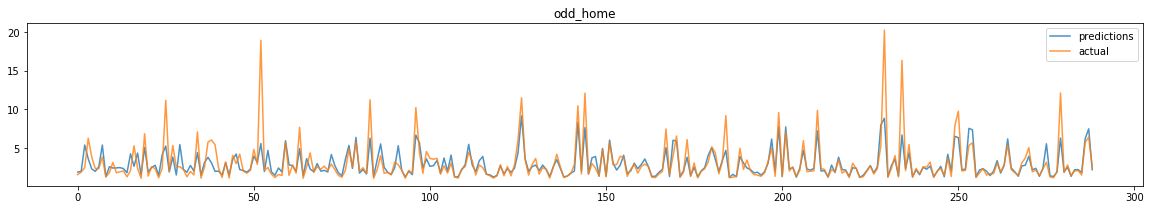

odd_home , neg MAE:  -0.8068104160332409
{'kneighborsregressor__n_neighbors': 18, 'kneighborsregressor__weights': 'distance'}


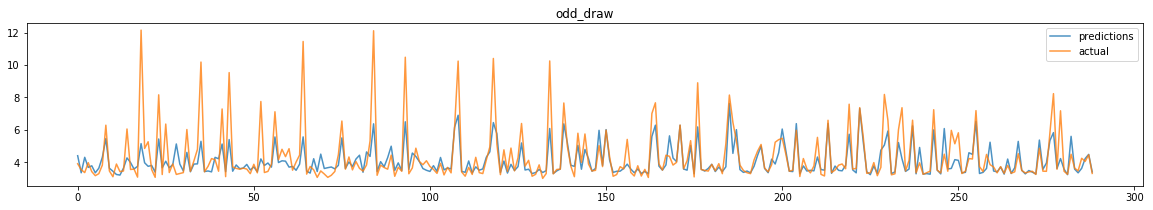

odd_draw , neg MAE:  -0.6117010189327201
{'kneighborsregressor__n_neighbors': 16, 'kneighborsregressor__weights': 'distance'}


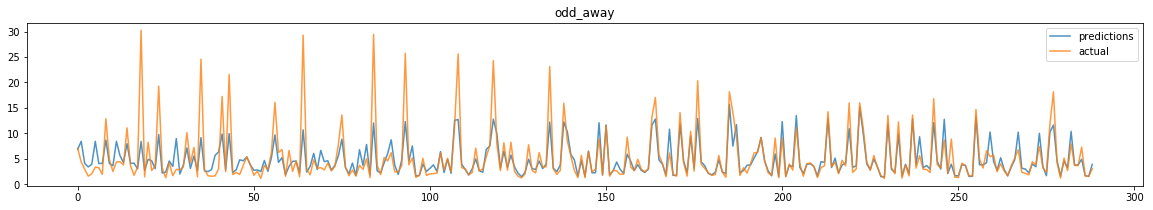

odd_away , neg MAE:  -1.6541398045286224
{'kneighborsregressor__n_neighbors': 19, 'kneighborsregressor__weights': 'uniform'}


In [ ]:
# GRID SEARCH (K-NEIGHBORS REGRESSOR, SCALER)

pipe = make_pipeline(scaler, knn_reg)
param_grid = {
    'kneighborsregressor__n_neighbors':range(1, 20), 
    'kneighborsregressor__weights':['uniform', 'distance']
}
grid = GridSearchCV(pipe, param_grid, cv=10, scoring="neg_mean_absolute_error")

for odd_type in ['odd_home', 'odd_draw', 'odd_away']:
    grid.fit(df_past_seasons[columns_to_use], df_past_seasons[odd_type])
    predictions = grid.predict(df_1819[columns_to_use])
    score = grid.score(df_1819[columns_to_use], df_1819[odd_type])
    
    plt.figure(figsize=(20, 3))
    plt.plot(np.arange(len(predictions)), predictions, alpha=0.8, label='predictions')
    plt.plot(np.arange(len(predictions)), df_1819[odd_type].values, alpha=0.8, label='actual')
    plt.title(odd_type)
    plt.legend()
    plt.show()
    print(odd_type, ', neg MAE: ', score)
    print(grid.cv_results_['params'][grid.best_index_])

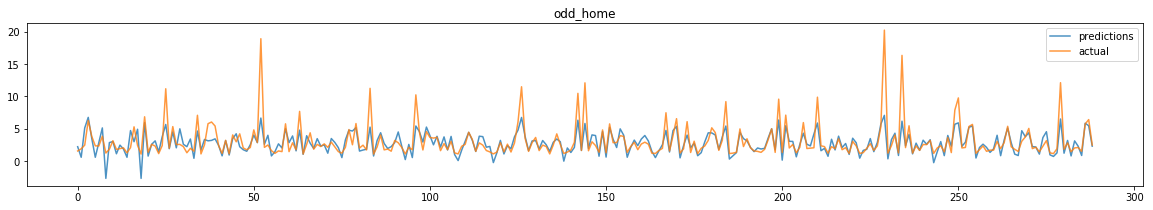

odd_home , neg MAE:  -0.9856495296625309


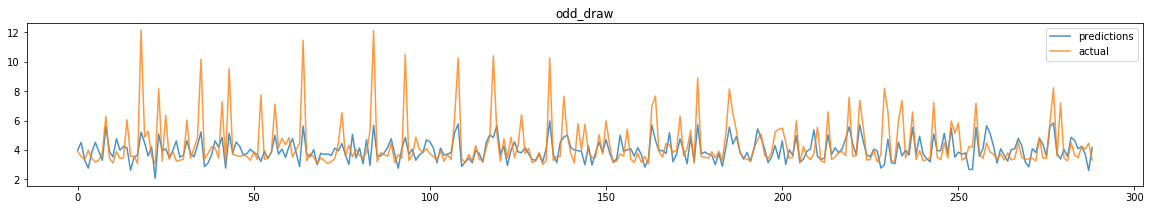

odd_draw , neg MAE:  -0.8892525559096569


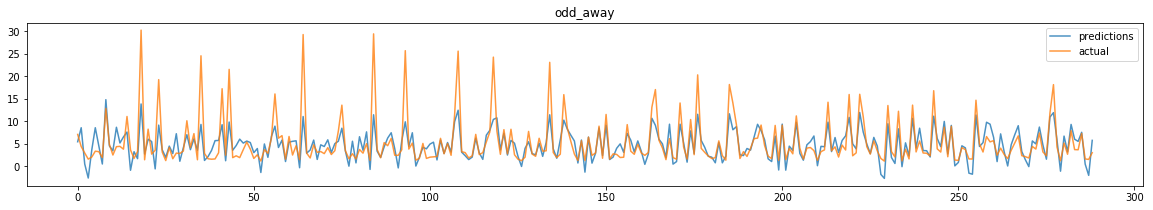

odd_away , neg MAE:  -2.159616835255578


In [ ]:
# FORWARD SELECTION

for odd_type in ['odd_home', 'odd_draw', 'odd_away']:
    lin_model = forward_selected(df_past_seasons[np.append(columns_to_use, odd_type)], odd_type)
    predictions = lin_model.predict(df_1819[np.append(columns_to_use, odd_type)])
    score = 0-mean_absolute_error(df_1819[odd_type].values, predictions.values)

    plt.figure(figsize=(20, 3))
    plt.plot(np.arange(len(predictions)), predictions, alpha=0.8, label='predictions')
    plt.plot(np.arange(len(predictions)), df_1819[odd_type].values, alpha=0.8, label='actual')
    plt.title(odd_type)
    plt.legend()
    plt.show()
    print(odd_type, ', neg MAE: ', score)

In [ ]:
df_current_season = df_1819
team_stats = getLastTeamStats(df_current_season)
H_W = []
H_WR = []
H_avg_diff = []
A_W = []
A_WR = []
A_avg_diff = []

for i in range(len(df_future_games)):
    game = df_future_games.loc[i]
    H_W.append(team_stats[game['HomeTeam']]['W'])
    H_WR.append(team_stats[game['HomeTeam']]['WR'])
    H_avg_diff.append(team_stats[game['HomeTeam']]['avg_diff'])
    A_W.append(team_stats[game['AwayTeam']]['W'])
    A_WR.append(team_stats[game['AwayTeam']]['WR'])
    A_avg_diff.append(team_stats[game['AwayTeam']]['avg_diff'])

df_future_games['H_W'] = H_W
df_future_games['H_WR'] = H_WR
df_future_games['H_avg_diff'] = H_avg_diff
df_future_games['A_W'] = A_W
df_future_games['A_WR'] = A_WR
df_future_games['A_avg_diff'] = A_avg_diff

In [ ]:
# PREDICT ODDS OF FUTURE GAMES USING GRIDSEARCH MODEL

pipe = make_pipeline(scaler, knn_reg)
param_grid = {
    'kneighborsregressor__n_neighbors':range(1, 20), 
    'kneighborsregressor__weights':['uniform', 'distance']
}
grid = GridSearchCV(pipe, param_grid, cv=10, scoring="neg_mean_absolute_error")

for odd_type in ['odd_home', 'odd_draw', 'odd_away']:
    grid.fit(df_past_seasons[columns_to_use], df_past_seasons[odd_type])
    predictions = grid.predict(df_future_games[columns_to_use])
    df_future_games['predicted_'+odd_type] = predictions

In [ ]:
# Predicted odds of future games

df_future_games[['HomeTeam', 'AwayTeam', 'predicted_odd_home', 'predicted_odd_draw', 'predicted_odd_away']].head()

### (3) Using Poisson with different features 

This model also uses poisson, but we replicated this model from [David Sheehan's study](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/). First we modified the  dataset so that it shows the number of goals each team scored when they were home or away. We only chose the features that is available to us. In addition to the features that Sheehan used, we also added the bettingwhich are from the prediction in the previous section.

* Team
* Opponent
* Goals = number of goals scored in the match
* Home = 1: HomeTeam & 0: AwayTeam
* odd_team = betting odds for the team
* odd_draw = betting odds for a draw
* odd_opponent = betting odds for the opponent

#### Dataset for the model

In [ ]:
# Take a home team and away team 
team_opponent_data_home = data_1819[['HomeTeam', 'AwayTeam', 'FTHG', 'odd_home', 'odd_draw', 'odd_away']]
team_opponent_data_home.columns = ['Team', 'Opponent', 'Goals', 'odd_team', 'odd_draw', 'odd_opponent']
team_opponent_data_home['Home'] = 1
team_opponent_data_away = data_1819[['AwayTeam', 'HomeTeam', 'FTAG', 'odd_away', 'odd_draw', 'odd_home']]
team_opponent_data_away.columns = ['Team', 'Opponent', 'Goals', 'odd_team', 'odd_draw', 'odd_opponent']
team_opponent_data_away['Home'] = 0

team_opponent_data = team_opponent_data_home.append(team_opponent_data_home).append(team_opponent_data_away)
team_opponent_data.head()

In [ ]:
#Perform poisson model
poisson_model = smf.glm(formula="Goals ~ Home + Team + Opponent + odd_team + odd_draw + odd_opponent", data=team_opponent_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

#### EPL standing table (3/2)

The below table is the EPL standing table on March 2nd, 2019. At this point, Man City was in the winning run in the EPL with 71 points. 

In [ ]:
ranking=pd.read_csv('./data/CurrentRanking.csv')
ranking

In [ ]:
future_matches = pd.read_csv('./data/betting_odds_prediction.csv')

This is our input dataset. We listed all the home teams and their opponent(away teams) for all remaining games. For each game, we predicted number of goals that home team and away team might score and gave 3 points to the team that are more likely to score more. The limitation of our model is that it was nearly impossilbe to have same score(goals) for both home and away team, so there was no draw in our result. After predicting results of each matches, we predicted that Manchester City will win the season with 98 points.

#### Input dataset

In [ ]:
future_matches.head()

In [ ]:
result = []
for index, row in future_matches.iterrows():
    home_score = poisson_model.predict(pd.DataFrame(data={'Team': row['HomeTeam'], 'Opponent': row['AwayTeam'],
                                       'Home':1, 'odd_team':row['predicted_odd_home'], 'odd_draw':row['predicted_odd_draw'],
                                        'odd_opponent':row['predicted_odd_away']},index=[1]))
    away_score = poisson_model.predict(pd.DataFrame(data={'Team': row['AwayTeam'], 'Opponent': row['HomeTeam'],
                                       'Home':0, 'odd_team':row['predicted_odd_away'], 'odd_draw':row['predicted_odd_draw'],
                                        'odd_opponent':row['predicted_odd_home']},index=[1]))
    if(home_score[1] > away_score[1]):
        ranking.iloc[ranking.loc[ranking['Team']==row.HomeTeam].index[0], ranking.columns.get_loc('Point')] = ranking.loc[ranking.Team == row.HomeTeam]['Point'].iloc[0] + 3
        result.append('H')
    elif(home_score[1] < away_score[1]):
        ranking.iloc[ranking.loc[ranking['Team']==row.AwayTeam].index[0], ranking.columns.get_loc('Point')] = ranking.loc[ranking.Team == row.AwayTeam]['Point'].iloc[0] + 3
        result.append('A')
    else:
        ranking.iloc[ranking.loc[ranking['Team']==row.HomeTeam].index[0], ranking.columns.get_loc('Point')] = ranking.loc[ranking.Team == row.HomeTeam]['Point'].iloc[0] + 1
        ranking.iloc[ranking.loc[ranking['Team']==row.AwayTeam].index[0], ranking.columns.get_loc('Point')] = ranking.loc[ranking.Team == row.AwayTeam]['Point'].iloc[0] + 1
        result.append('D')
future_matches['predicted_result'] = result

#### Predicted tanding table

In [ ]:
# Prediction
ranking.sort_values('Point', ascending=False)